(447, 245)
(256, 256, 1)


Using TensorFlow backend.


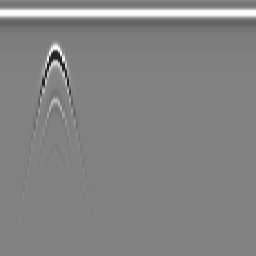

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import signal
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from glob import glob
import math
from sklearn.model_selection import train_test_split
from PIL.ImageOps import invert
import jeepr
from keras.utils import plot_model

np.random.seed(1234)
tf.set_random_seed(1234)

os.environ["CUDA_VISIBLE_DEVICES"]="0"


img = image.load_img("/home/will/dev/gpr-learn/Metallic_plastic_none/Metallic 500/metallic98.png", color_mode='grayscale')
print(img.size)
img = img.resize((256, 256))
test = image.img_to_array(img)[:, :, :]
print(test.shape)
img = image.array_to_img(test)
img

In [2]:
none_paths = glob('/home/will/dev/gpr-learn/Metallic_plastic_none/None 500/*')
metallic_paths = glob('/home/will/dev/gpr-learn/Metallic_plastic_none/Metallic 500/*')
plastic_paths = glob('/home/will/dev/gpr-learn/Metallic_plastic_none/Plastic 500/*')

def load_img(path):
    img = image.load_img(path, color_mode='grayscale')
    img = img.resize((256,256))
    img = invert(img)
    return image.img_to_array(img)

none_scans = np.array([load_img(path) for path in none_paths])
metallic_scans = np.array([load_img(path) for path in metallic_paths])
plastic_scans = np.array([load_img(path) for path in plastic_paths])

none_labels = np.zeros((500,))
metallic_labels = np.ones((500,))
plastic_labels = np.ones((500,)) * 2

In [3]:
y = np.concatenate([none_labels, metallic_labels, plastic_labels]).astype(np.int32)
a_scans = np.concatenate([none_scans, metallic_scans, plastic_scans])

print(y.shape)
print(a_scans.shape)

(1500,)
(1500, 256, 256, 1)


In [4]:
np.save('a_scans.npy', a_scans)
np.save('labels.npy', y)

In [5]:
from keras.datasets import mnist
from keras.layers.merge import _Merge, multiply
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Embedding
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])


class ACWGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 3
        self.latent_dim = 100
        self.losslog = []
        

        self.n_critic = 5
        #optimizer = RMSprop(lr=0.00005)
        optimizer = Adam(0.0002, 0.5)
        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        
        # Generate image based of noise (fake sample) and add label to the input 
        label = Input(shape=(1,))
        fake_img = self.generator([z_disc, label])

        # Discriminator determines validity of the real and fake images
        fake, _ = self.critic(fake_img)
        valid, label_prob = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        
        # Determine validity of weighted sample
        validity_interpolated, _ = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, label, z_disc], outputs=[valid, fake, validity_interpolated, label_prob])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                        self.wasserstein_loss,
                                        partial_gp_loss,
                                        'sparse_categorical_crossentropy'],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 1, 10],
                                        metrics=['accuracy'])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(100,))
        # add label to the input
        #label = Input(shape=(1,))
        # Generate images based of noise
        img = self.generator([z_gen, label])
        # Discriminator determines validity
        valid, label_pred = self.critic(img)
        # Defines generator model
        self.generator_model = Model([z_gen, label], [valid, label_pred])
        self.generator_model.compile(loss=[self.wasserstein_loss, 'sparse_categorical_crossentropy']
                                     optimizer=optimizer)
        
        
        
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 128)))
        
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(256, kernel_size=5, padding="same"))
        model.add(Activation("relu"))
        
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=5, padding="same"))
        model.add(Activation("relu"))
        
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=5, padding="same"))
        model.add(Activation("relu"))
        
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(32, kernel_size=5, padding="same"))
        model.add(Activation("relu"))
        
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(16, kernel_size=5, padding="same"))
        model.add(Activation("relu"))
        
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        #model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, 100)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_critic(self):

        model = Sequential()
        model.add(Conv2D(16, kernel_size=5, strides=2, padding="same", input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.3))
        #model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=5, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.3))
        #model.add(Dropout(0.25))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=5, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.3))
        #model.add(Dropout(0.25))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.3))
        #model.add(Dropout(0.25))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=5, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.3))
        #model.add(Dropout(0.25))
        model.add(Flatten())
        #model.summary()

        img = Input(shape=self.img_shape)
        
        features = model(img)
        # Determine validity and label of the image
        validity = Dense(1, activation=None)(features)
        label_prob = Dense(self.num_classes, activation="softmax")(features)

        return Model(img, [validity, label_prob])

    def train(self, epochs, batch_size=16, sample_interval=50):

        # Load the dataset
        X_train, X_test, y_train, y_test = train_test_split(a_scans, y, test_size=0.3)

        # Configure inputs
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        y_train = y_train.reshape(-1, 1)

         # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake =  np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
        
        for epoch in range(epochs+1):
            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs, labels = X_train[idx], y_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, labels, noise], [valid, fake, dummy, labels])

            # ---------------------
            #  Train Generator
            # ---------------------
            sampled_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)
            g_loss = self.generator_model.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            
            self.losslog.append([d_loss[0], g_loss])
            
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f, op_acc: %.2f%%] [G loss: %f]" % (
                epoch, d_loss[0], d_loss[3], 100*d_loss[-1], g_loss))
                #print("Evaluating Model...")
                #idx = np.random.randint(0, X_test.shape[0], batch_size)
                #imgs, labels = X_test[idx], y_test[idx]
                #d_loss = self.critic_model.eval_on_batch([imgs, labels, noise], [valid, fake, dummy, labels])
                #print ("%d [D loss: %f] [Aux loss: %f]" % (epoch, d_loss[0], d_loss[-1]))
                self.sample_images(epoch)
                self.generator.save_weights('generator_same_labels', overwrite=True)
                self.critic.save_weights('discriminator_same_labels', overwrite=True)
                with open('loss_same_labels.log', 'w') as f:
                    f.writelines('d_loss, g_loss\n')
                    for each in self.losslog:
                        f.writelines('%s, %s\n'%(each[0], each[1]))
                        
    def sample_images(self, epoch):
        r, c = 2, 2
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray_r')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.critic, "discriminator")
        
    def plot_loss(self, gen_loss, disc_loss):
        gen_loss = np.array(gen_loss)
        disc_loss = np.array(disc_loss)
        plt.plot(gen_loss)
        plt.savefig('saved_model/gen_loss.png')
        plt.plot(disc_loss)
        plt.savefig('saved_model/disc_loss.png')


In [7]:
acgan = ACWGAN()

#acgan.train(epochs=50000, batch_size=32, sample_interval=500)

In [9]:
model = ACWGAN().build_generator()
plot_model(model, to_file='model.png')
#model.load_weights('generator')

In [ ]:

noise = np.random.normal(0, 1, (1, 100))
sampled_labels = np.array([2])
print(sampled_labels)
gen_imgs = model.predict([noise, sampled_labels])
gen_imgs = 0.5 * gen_imgs + 0.5
gen_imgs.shape
invert(image.array_to_img(np.squeeze(gen_imgs, 0)))